In [1]:
import os
import git
from pathlib import Path

from typing import List
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
from IPython.display import clear_output
import pylustrator

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "results", "combined_results"))
np.random.seed(0)
plots_path = os.path.join(ROOT_DIR, "poster", "plots")

In [5]:
find_master_dfs('..\case-studies')

['c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\combined_results\\..\\case-studies\\experiments\\scaleTesting\\_\\samplePrior\\CSVs\\master_df.csv',
 'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\combined_results\\..\\case-studies\\pastis\\full\\fourier\\gray\\CSVs\\master_df.csv',
 'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\combined_results\\..\\case-studies\\pastis\\full\\wavelet\\gray\\CSVs\\master_df.csv',
 'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\combined_results\\..\\case-studies\\scaleTesting\\wavelet\\full\\gray\\CSVs\\master_df.csv',
 'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\combined_results\\..\\case-studies\\scaleTesting\\wavelet\\full\\laplace\\CSVs\\master_df.csv',
 'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\combined_results\\..\\case-studies\\spaceNet\\full\\fourier\\gray\\C

In [11]:
def variance_prior(r, eta, scale=1):
    beta = (eta+1.5)/r
    var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
    return var_prior

def kurtosis_prior(r, eta, fisher=True):
    beta = (eta+1.5)/r
    kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2 
    if fisher:
        return kurtosis - 3
    else:
        return kurtosis 

fixed_palette = {
    'gray': 'xkcd:gray',
    'green': 'xkcd:shamrock green',
    'red': 'xkcd:light red',
    'blue': 'xkcd:blue',
}


def find_master_dfs(root_dir: str) -> List[str]:
    root_path = Path(root_dir)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    master_df_paths = []
    for current_dir, _, files in os.walk(root_path):
        if 'master_df.csv' in files:
            master_df_path = Path(os.path.join(current_dir, 'master_df.csv'))
            master_df_paths.append(str(master_df_path.absolute()))
    return master_df_paths

relevant_cols = ['group', 'obs_var', 'var_lower', 'var_upper', 'obs_kurt', 'kurt_lower',
       'kurt_upper', 'total_samples', 'initial_r', 'initial_eta', 'initial_scale',
       'kstest_stat_initial', 'kstest_stat_cutoff_0.05',
       'best_r', 'best_eta', 'best_scale', 'kstest_stat_best',
       'n_pval_0.05', 'param_gaussian',
       'kstest_stat_gaussian', 'kstest_pval_gaussian', 'param_laplace',
       'kstest_stat_laplace', 'kstest_pval_laplace', 'param_t',
       'kstest_stat_t', 'kstest_pval_t', 'kstest_pval_gengamma', 'dataset', 'transform', 'size', 'channel']

all_paths = find_master_dfs('..\case-studies')[1:3]
all_master_dfs = []

for path in all_paths:
    
    dataset, size, transform, channel, _, _ = Path(path).parts[-6:]
    master_df = pd.read_csv(path)
    master_df = master_df.rename(columns={master_df.columns[0]: 'group'})#.set_index('group')
    master_df['dataset'] = dataset
    master_df['transform'] = transform
    master_df['size'] = size
    master_df['channel'] = channel

    all_master_dfs.append(master_df[relevant_cols])
    
main_df = pd.concat(all_master_dfs)
main_df['prior_var'] = main_df.apply(lambda row : variance_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
main_df['prior_kurt'] = main_df.apply(lambda row : kurtosis_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
main_df['gaussian_kurt'] = np.zeros(main_df.shape[0])
main_df['laplace_kurt'] = 3*np.ones(main_df.shape[0])
main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r'] 

frequency_map = pd.read_csv(os.path.join(ROOT_DIR, "transformed-data", "master-frequency-map.csv")).set_index(['dataset', 'transform', 'group'])
main_df = main_df.set_index(['dataset', 'transform', 'group']).merge(frequency_map, left_index = True, right_index=True).reset_index()
main_df

C:\Users\yashd\AppData\Local\Temp\ipykernel_40196\1155259362.py:8: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
C:\Users\yashd\AppData\Local\Temp\ipykernel_40196\1155259362.py:8: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
C:\Users\yashd\AppData\Local\Temp\ipykernel_40196\1155259362.py:8: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


,dataset,transform,group,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,...,kstest_pval_t,kstest_pval_gengamma,size,channel,prior_var,prior_kurt,gaussian_kurt,laplace_kurt,best_beta,frequency
0,pastis,fourier,2,10.134422,9.643435,10.646572,1.621352,1.183683,2.159779,31800.0,...,1.079090e-12,8.496052e-01,full,gray,1.617578e+01,1.240543,0.0,3.0,5.846154,0.061242
1,pastis,fourier,5,5.424390,5.164831,5.694692,1.556881,1.034867,2.247035,41340.0,...,2.570410e-17,9.489054e-01,full,gray,3.298482e+00,1.041902,0.0,3.0,3.125000,0.078689
2,pastis,fourier,8,2.974848,2.833664,3.120628,1.541575,1.065818,2.175573,66780.0,...,5.918010e-28,5.154834e-01,full,gray,1.109293e+07,1.213453,0.0,3.0,47.500000,0.098453
3,pastis,fourier,11,1.695055,1.610400,1.784300,1.922300,1.152667,3.322009,104940.0,...,3.482490e-42,9.338582e-01,full,gray,4.371203e+01,1.154355,0.0,3.0,8.245614,0.123565
4,pastis,fourier,14,0.926228,0.881725,0.973125,1.705795,1.083743,3.005845,162180.0,...,1.991250e-66,2.515613e-01,full,gray,1.080914e+00,0.854362,0.0,3.0,1.317365,0.155566
5,pastis,fourier,17,0.518186,0.492855,0.544779,1.771588,1.108579,3.490519,257580.0,...,2.707250e-92,9.994724e-01,full,gray,1.398215e+01,1.288877,0.0,3.0,5.454545,0.196261
6,pastis,fourier,20,0.260627,0.247789,0.274535,1.956200,1.143715,5.900508,381600.0,...,4.194530e-135,9.742285e-01,full,gray,7.993909e+00,1.300939,0.0,3.0,4.383562,0.247131
7,pastis,fourier,23,0.122159,0.116055,0.128693,2.041856,1.252694,3.881752,610560.0,...,1.621600e-211,1.633382e-01,full,gray,2.913206e+00,1.215060,0.0,3.0,2.736842,0.311794
8,pastis,fourier,26,0.049178,0.046151,0.053056,5.035482,1.824682,19.982931,973080.0,...,2.829970e-295,6.432158e-01,full,gray,2.818872e+08,1.878312,0.0,3.0,47.000000,0.392401
9,pastis,fourier,29,0.015548,0.014031,0.017973,20.922686,4.499840,88.633370,1376940.0,...,0.000000e+00,1.327565e-03,full,gray,4.404421e+12,2.155719,0.0,3.0,76.000000,0.493909


## How do we compare to other priors?

In [12]:
fontsize = 20
markersize = 10
labelsize = 20
markertypes = ['D', 'o', '+']
labels = ['GenGamma', 'Laplace', 'Gaussian', 'Student-t', r'$\alpha=0.05$']
points = [Line2D([0], [0], color='red', linestyle='', marker='X', markersize=12)] + [Line2D([0], [0], color='k', linestyle='', marker=m, markersize=10) for m in markertypes] + [Line2D([0], [0], color='k', linestyle='-', linewidth=2)]

## END RESULT

C:\Users\yashd\AppData\Local\Temp\ipykernel_40196\1439436849.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_best', color='red', palette=fixed_palette, marker='X', ax=axes[0], markersize = markersize)
C:\Users\yashd\AppData\Local\Temp\ipykernel_40196\1439436849.py:32: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_best', color='red', palette=fixed_palette, marker='X', ax=axes[1], markersize = markersize)


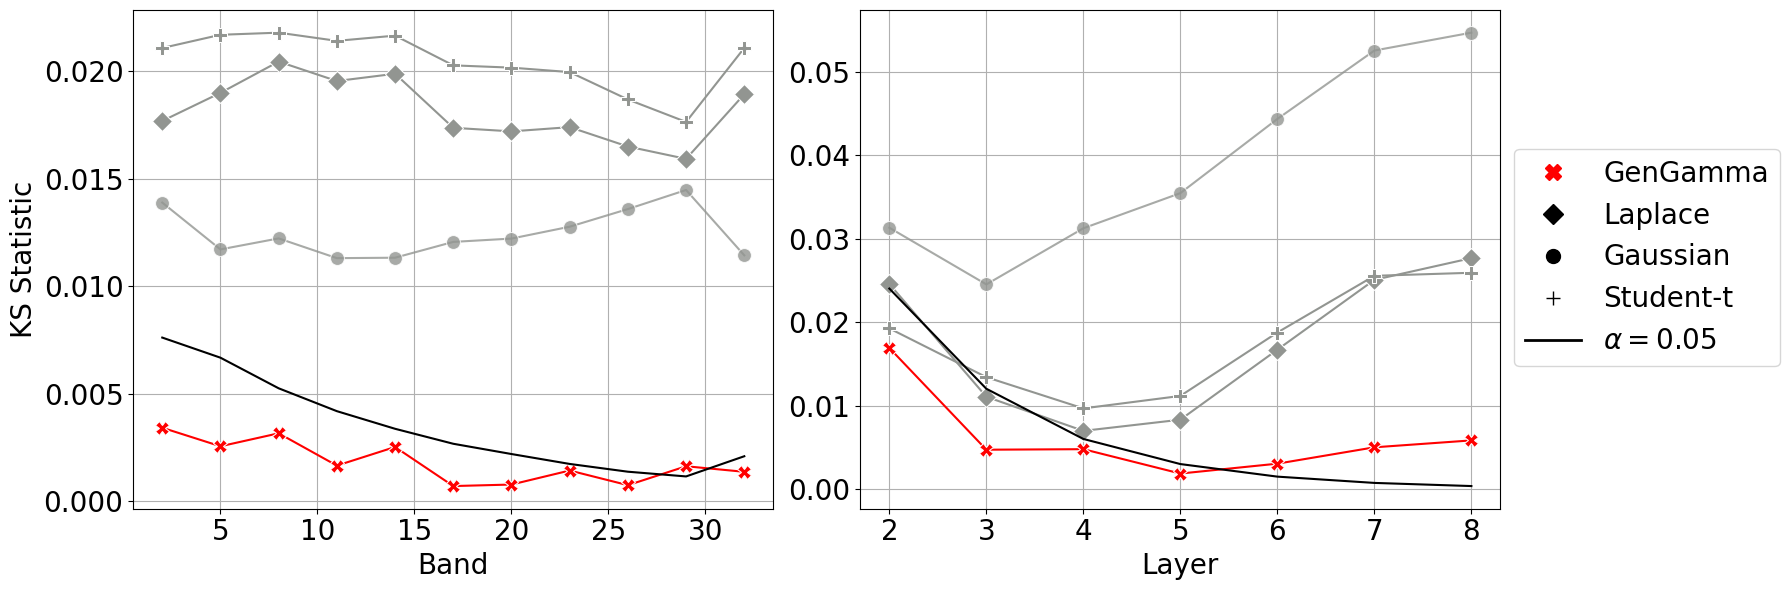

In [16]:
hue = 'channel'
dataset_name = 'pastis'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
#fig.suptitle(f"Fits across different priors", fontsize=fontsize)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', color='red', palette=fixed_palette, marker='X', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
axes[0].set_xlabel("Band", fontsize=fontsize)
axes[0].set_ylabel("KS Statistic", fontsize=fontsize)
axes[0].legend(points, labels, fontsize = 12).set_visible(False)
axes[0].grid(True)
# axes[0].set_title("Fits across different priors under Fourier ", fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', color='red', palette=fixed_palette, marker='X', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])
axes[1].set_xlabel("Layer", fontsize=fontsize)
axes[1].set_ylabel("", fontsize=fontsize)
axes[1].legend(points, labels, fontsize = 20, bbox_to_anchor = (1, 0.75))#.set_visible(False)
axes[1].grid(True)
# axes[1].set_title("Fits across different priors: Wavelet", fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.figure.savefig(os.path.join(plots_path, f"ksstat_across_priors_{dataset_name}_3.jpg"), dpi=1000, bbox_inches='tight')

# Extract tick parameters for both axes
x_tick_values_0 = axes[0].get_xticks()
y_tick_values_0 = axes[0].get_yticks()
x_tick_values_1 = axes[1].get_xticks()
y_tick_values_1 = axes[1].get_yticks()

# Extract xlim and ylim for both axes
x_lim_0 = axes[0].get_xlim()
y_lim_0 = axes[0].get_ylim()
x_lim_1 = axes[1].get_xlim()
y_lim_1 = axes[1].get_ylim()

C:\Users\yashd\AppData\Local\Temp\ipykernel_4372\2481117272.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_best', color='red', palette=fixed_palette, marker='X', ax=ax, markersize=markersize)


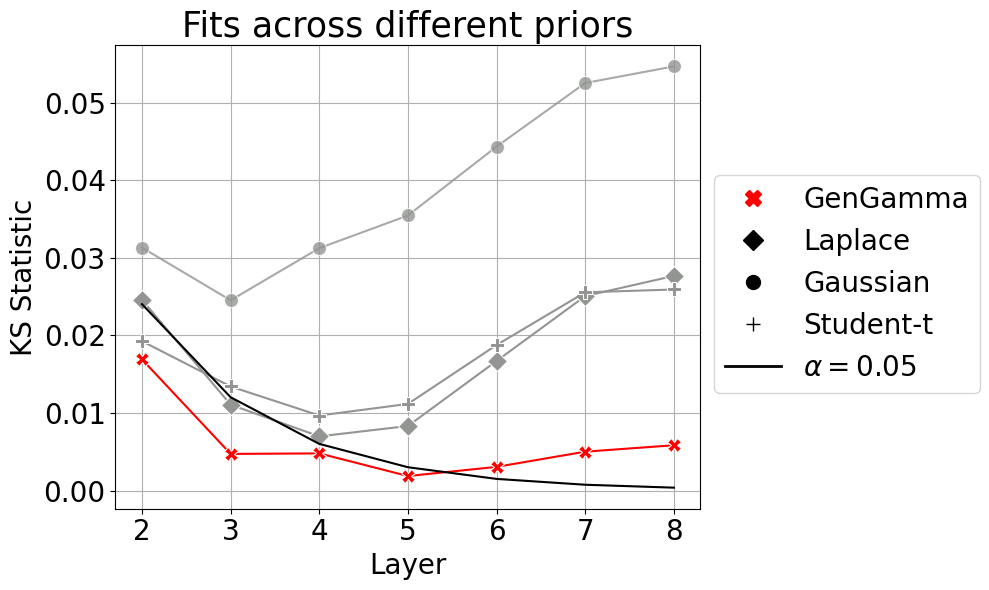

In [29]:
transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

fig, ax = plt.subplots(figsize=(10, 6))
#fig.suptitle(f"Fits across different priors", fontsize=fontsize+2)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=ax, markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=ax, markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=ax, markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', color='red', palette=fixed_palette, marker='X', ax=ax, markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=ax)

ax.set_xlabel("Layer", fontsize=fontsize)
ax.set_ylabel("KS Statistic", fontsize=fontsize)
ax.legend(points, labels, fontsize=20, bbox_to_anchor=(1, 0.75))
ax.grid(True)
ax.set_title("Fits across different priors", fontsize=fontsize + 5)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, f"ksstat_across_priors_{dataset_name}_wavelet.jpg"), dpi=1000, bbox_inches='tight')


## Step 1: Single-Channel (Gray) Prior 

C:\Users\yashd\AppData\Local\Temp\ipykernel_4372\3067972314.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp[temp['channel'] == 'gray'], x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize=markersize)


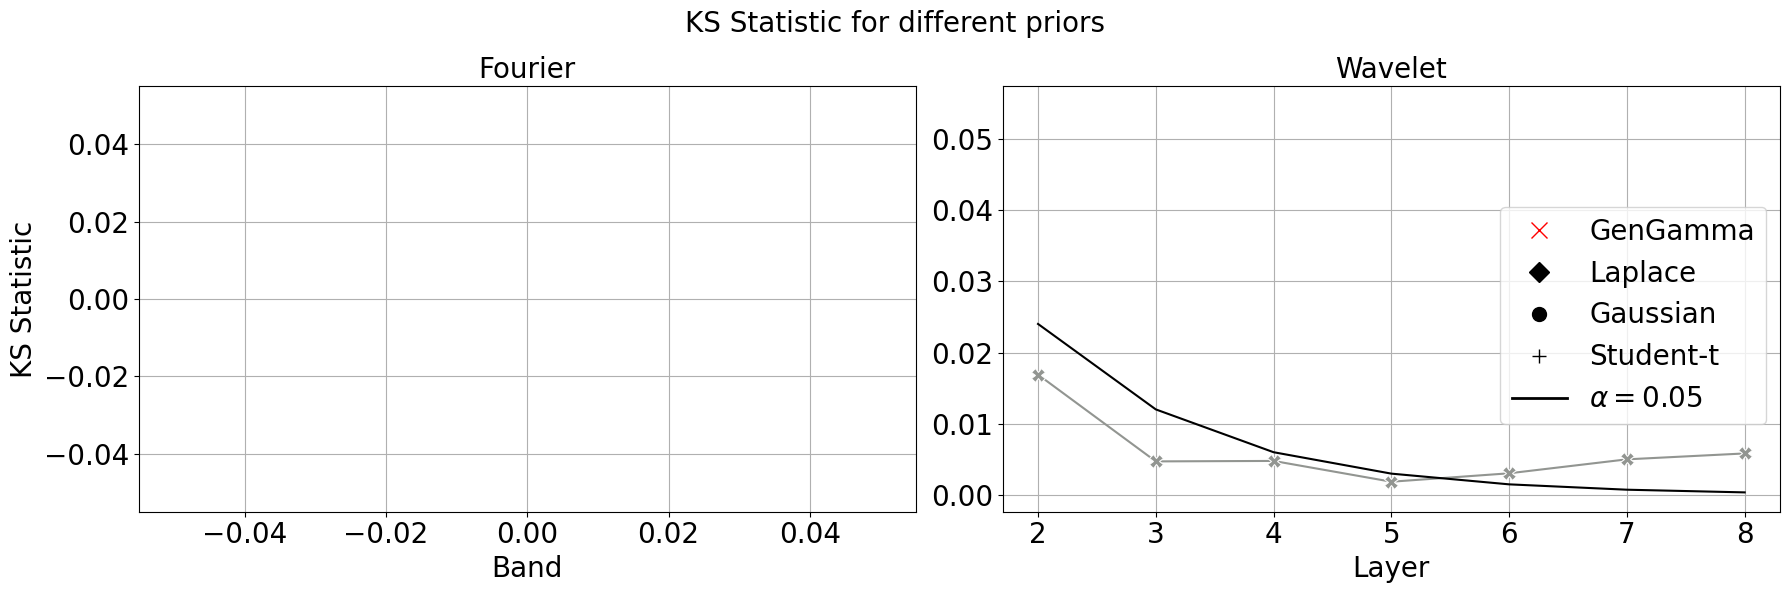

In [5]:
hue = 'channel'
dataset_name = 'pastis'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f"KS Statistic for different priors", fontsize=fontsize)

# sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize = markersize)
# sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize = markersize)
# sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp[temp['channel'] == 'gray'], x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
axes[0].set_xlabel("Band", fontsize=fontsize)
axes[0].set_ylabel("KS Statistic", fontsize=fontsize)
axes[0].legend(points, labels, fontsize=12).set_visible(False)
axes[0].grid(True)
axes[0].set_title("Fourier", fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)
axes[0].set_xticks(x_tick_values_0)
axes[0].set_yticks(y_tick_values_0)
axes[0].set_xlim(x_lim_0)
axes[0].set_ylim(y_lim_0)

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

# sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize = markersize)
# sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize = markersize)
# sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp[temp['channel'] == 'gray'], x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])
axes[1].set_xlabel("Layer", fontsize=fontsize)
axes[1].set_ylabel("", fontsize=fontsize)

axes[1].legend(points, labels, fontsize=20, bbox_to_anchor=(1, 0.75))
axes[1].grid(True)
axes[1].set_title("Wavelet", fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
axes[1].set_xticks(x_tick_values_1)
axes[1].set_yticks(y_tick_values_1)
axes[1].set_xlim(x_lim_1)
axes[1].set_ylim(y_lim_1)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.figure.savefig(os.path.join(plots_path, f"ksstat_across_priors_{dataset_name}_1.jpg"), dpi=1000, bbox_inches='tight')

C:\Users\yashd\AppData\Local\Temp\ipykernel_4372\3180808349.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize=markersize)
C:\Users\yashd\AppData\Local\Temp\ipykernel_4372\3180808349.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize=markersize)
C:\Users\yashd\AppData\Local\Temp\ipykernel_4372\3180808349.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize=markersize)
C:\Users\yashd\AppData\Local\Temp\ipykernel_4372\3180808349.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assig

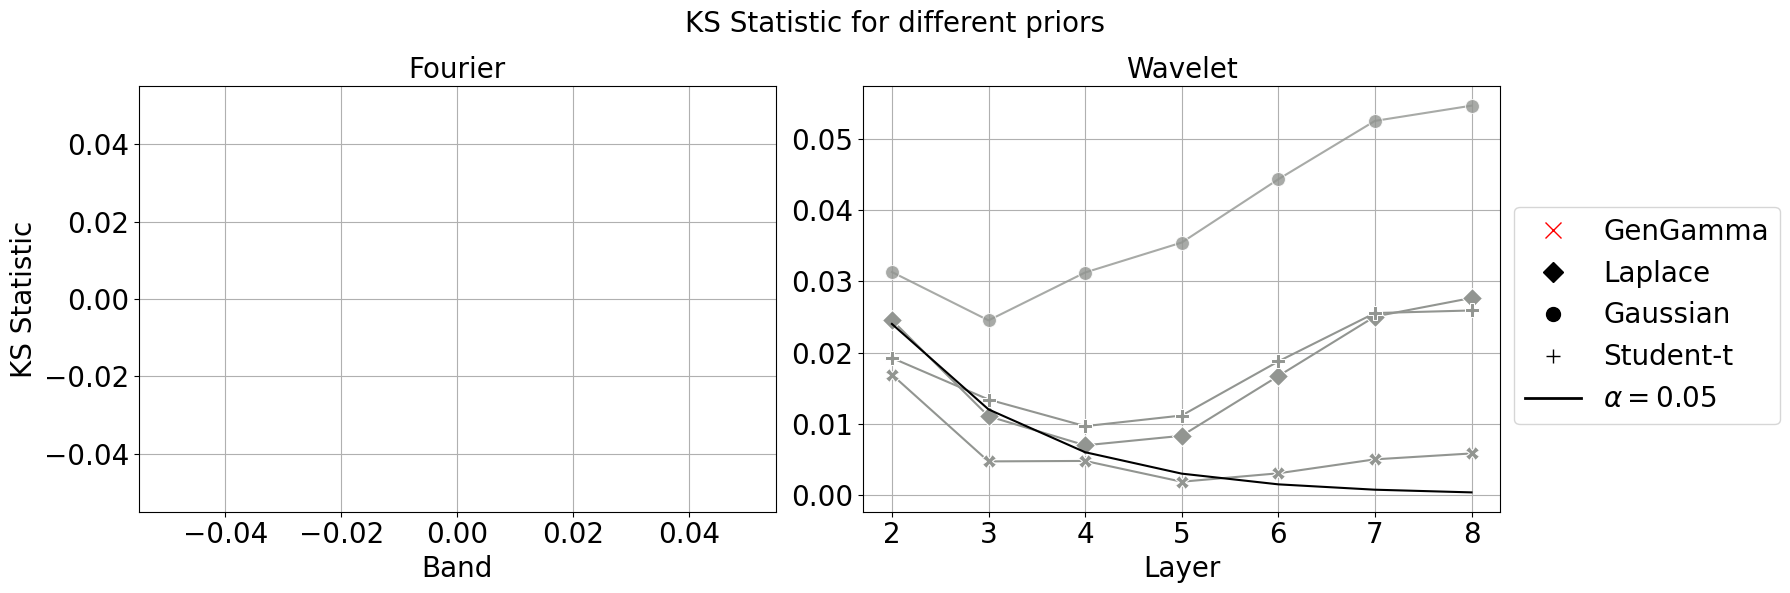

In [6]:
hue = 'channel'
dataset_name = 'pastis'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
channel_filter = (main_df['channel'] == 'gray')
temp = main_df[dataset_filter & transform_filter & channel_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f"KS Statistic for different priors", fontsize=fontsize)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
axes[0].set_xlabel("Band", fontsize=fontsize)
axes[0].set_ylabel("KS Statistic", fontsize=fontsize)
axes[0].legend(points, labels, fontsize=12).set_visible(False)
axes[0].grid(True)
axes[0].set_title("Fourier", fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)
axes[0].set_xticks(x_tick_values_0)
axes[0].set_yticks(y_tick_values_0)
axes[0].set_xlim(x_lim_0)
axes[0].set_ylim(y_lim_0)

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter & channel_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])
axes[1].set_xlabel("Layer", fontsize=fontsize)
axes[1].set_ylabel("", fontsize=fontsize)
axes[1].legend(points, labels, fontsize=20, bbox_to_anchor=(1, 0.75))
axes[1].grid(True)
axes[1].set_title("Wavelet", fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
axes[1].set_xticks(x_tick_values_1)
axes[1].set_yticks(y_tick_values_1)
axes[1].set_xlim(x_lim_1)
axes[1].set_ylim(y_lim_1)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.figure.savefig(os.path.join(plots_path, f"ksstat_across_priors_{dataset_name}_2.jpg"), dpi=1000, bbox_inches='tight')

C:\Users\yashd\AppData\Local\Temp\ipykernel_4372\1834747995.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize = markersize)
C:\Users\yashd\AppData\Local\Temp\ipykernel_4372\1834747995.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize = markersize)
C:\Users\yashd\AppData\Local\Temp\ipykernel_4372\1834747995.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize = markersize)
C:\Users\yashd\AppData\Local\Temp\ipykernel_4372\1834747995.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been

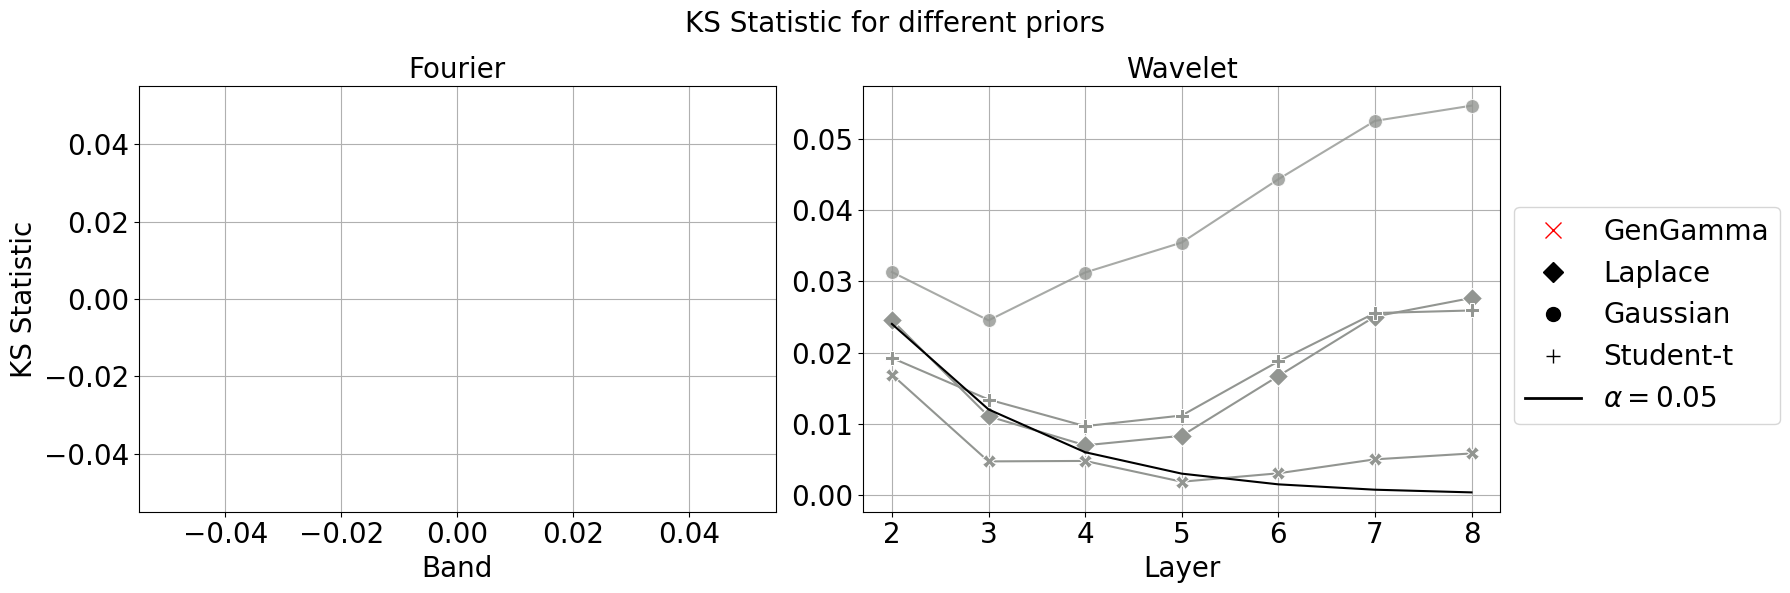

In [7]:
hue = 'channel'
dataset_name = 'pastis'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f"KS Statistic for different priors", fontsize=fontsize)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
axes[0].set_xlabel("Band", fontsize=fontsize)
axes[0].set_ylabel("KS Statistic", fontsize=fontsize)
axes[0].legend(points, labels, fontsize = 12).set_visible(False)
axes[0].grid(True)
axes[0].set_title("Fourier", fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])
axes[1].set_xlabel("Layer", fontsize=fontsize)
axes[1].set_ylabel("", fontsize=fontsize)
axes[1].legend(points, labels, fontsize = 20, bbox_to_anchor = (1, 0.75))#.set_visible(False)
axes[1].grid(True)
axes[1].set_title("Wavelet", fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.figure.savefig(os.path.join(plots_path, f"ksstat_across_priors_{dataset_name}.jpg"), dpi=1000, bbox_inches='tight')